**`Import all the necessary libraries`**

In [14]:
import csv
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_squared_error

sns.set()
sns.set(style="whitegrid", color_codes=True)
# Ignore warnings
warnings.filterwarnings("ignore")
%matplotlib inline

**`Load the dataset and do perform data cleaning`**

In [2]:
df = pd.read_csv('hybrid-model-forecasting-dataset.csv')
df.dropna(axis=1, how='all', inplace=True)
df['Datetime']=pd.to_datetime(df['Datetime'], format='mixed')
df.set_index('Datetime', inplace=True)
df.index = pd.date_range(start=df.index[0],
                         periods=len(df), freq='H')

**`Initial EDA`**

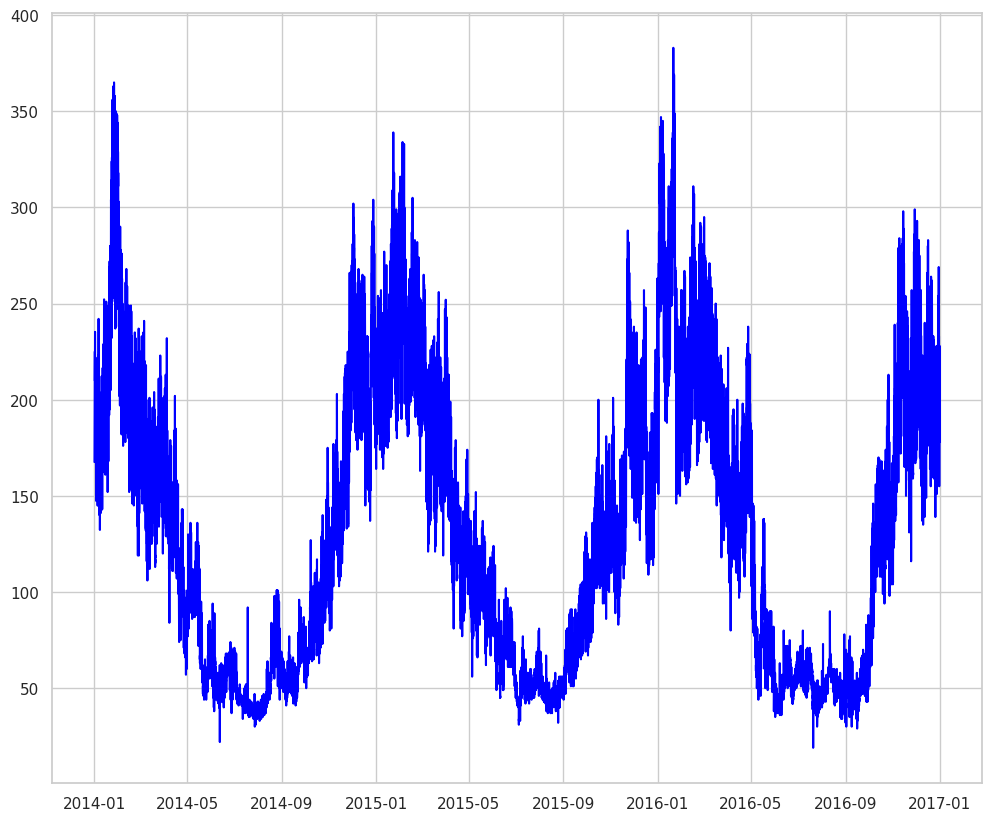

In [3]:
# Plotting x against y
plt.figure(figsize=(12, 10))  # Set the figure size
plt.plot(df['polloution'], color='blue')
plt.show()

**`Decompose the pollution time series into E, T, S`**

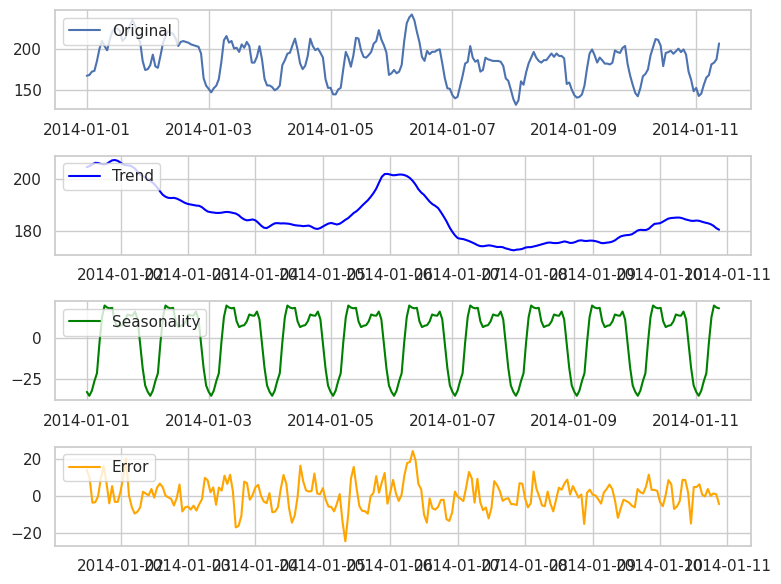

In [4]:
ts = df['polloution'][:250]

# Perform Error, Trend and Seasonal decomposition
result = seasonal_decompose(ts, model='additive')

# Plot the decomposition
plt.figure(figsize=(8, 6))

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Error', color='orange')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [5]:
trnd = result.trend.dropna()
season = result.seasonal.dropna()
error = result.resid.dropna()

**`Train test split of Trend, Season and Error components`**

In [6]:
trend_train, trend_test = train_test_split(trnd, test_size=0.2, shuffle=False)
season_train, season_test = train_test_split(season, test_size=0.2, shuffle=False)
error_train, error_test = train_test_split(error, test_size=0.2, shuffle=False)

**`Check the stationarity of Seasonal data`**

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(season_train)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -16.33832022915397
p-value: 3.0132415712678645e-29
Critical Values: {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}


**`Defining functions for model evaluation and hyper-parameter tuning`**

**`Evaluating ARIMA only on sample 100`**

In [9]:
ts_data = ts

# Perform train-test split
train_size = int(len(ts_data) * 0.8)
train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]


In [18]:
def evaluate_arima_model(train_data, test_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = math.sqrt(mse)
    r2 = r2_score(test_data, predictions)
    return mse, rmse, r2


In [19]:
def evaluate_models(train_data, test_data, p_values, d_values, q_values, filename='arima_results.csv'):
    best_score, best_cfg = float("inf"), None
    all_orders = []
    all_order_mse = []
    all_order_rmse = []
    all_order_r2 = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse, rmse, r2 = evaluate_arima_model(train_data, test_data, order)
                    all_orders.append(order)
                    all_order_mse.append(mse)
                    all_order_rmse.append(rmse)
                    all_order_r2.append(r2)

                    if mse < best_score:
                        best_score, best_cfg = mse, order

                    print(f'ARIMA{order} MSE={mse:.3f} RMSE={rmse:.3f} R-squared={r2:.3f}')
                except Exception as e:
                    print(f"Error in {order}: {str(e)}")
                    continue

    if best_cfg is not None:
        df = pd.DataFrame({
            'Order': all_orders,
            'MSE': all_order_mse,
            'RMSE': all_order_rmse,
            'R-squared': all_order_r2
        })
        df = df.round({'MSE': 3, 'RMSE': 3, 'R-squared': 3})

        df.to_csv(filename, index=False)
        print(f'Best ARIMA{best_cfg} MSE={best_score:.3f}')
        return best_cfg, all_orders, all_order_mse
    else:
        print("No valid configuration found.")
        return None, [], []


ARIMA(33, 0, 20) MSE=127.189 RMSE=11.278 R-squared=0.655
ARIMA(33, 0, 21) MSE=139.019 RMSE=11.791 R-squared=0.623
ARIMA(33, 0, 22) MSE=126.692 RMSE=11.256 R-squared=0.657
ARIMA(33, 0, 23) MSE=119.856 RMSE=10.948 R-squared=0.675
ARIMA(33, 1, 20) MSE=74.611 RMSE=8.638 R-squared=0.798
ARIMA(33, 1, 21) MSE=76.475 RMSE=8.745 R-squared=0.793
ARIMA(33, 1, 22) MSE=78.237 RMSE=8.845 R-squared=0.788
ARIMA(33, 1, 23) MSE=104.481 RMSE=10.222 R-squared=0.717
ARIMA(34, 0, 20) MSE=160.885 RMSE=12.684 R-squared=0.564
ARIMA(34, 0, 21) MSE=160.443 RMSE=12.667 R-squared=0.565
ARIMA(34, 0, 22) MSE=132.881 RMSE=11.527 R-squared=0.640
ARIMA(34, 0, 23) MSE=105.123 RMSE=10.253 R-squared=0.715
ARIMA(34, 1, 20) MSE=76.070 RMSE=8.722 R-squared=0.794
ARIMA(34, 1, 21) MSE=73.536 RMSE=8.575 R-squared=0.801
ARIMA(34, 1, 22) MSE=76.946 RMSE=8.772 R-squared=0.791
ARIMA(34, 1, 23) MSE=94.266 RMSE=9.709 R-squared=0.745
ARIMA(35, 0, 20) MSE=210.426 RMSE=14.506 R-squared=0.430
ARIMA(35, 0, 21) MSE=185.798 RMSE=13.631 R-sq

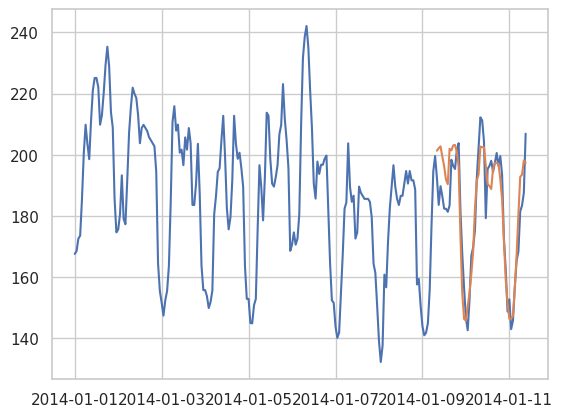

In [21]:

# Define the range of p, d, q values for hyperparameter tuning
p_values = range(33, 39)
d_values = range(0, 2)
q_values = range(20, 24)

# Find the best ARIMA hyperparameters
best_order, all_orders, all_order_mse = evaluate_models(train,
                                                        test,
                                                        p_values,
                                                        d_values,
                                                        q_values)

# Final model training
final_model = ARIMA(train, order=best_order)
final_model_fit = final_model.fit()


# Forecasting with the final model
forecast = final_model_fit.forecast(steps=len(test))
# 'forecast' contains predictions for the test setrange(0, 3)

# Evaluate the final model
mse = mean_squared_error(test, forecast)
print(f'Final ARIMA{best_order} MSE={mse:.3f}')

plt.plot(ts)
plt.plot(forecast)


Final ARIMA(36, 1, 23) MSE=72.157


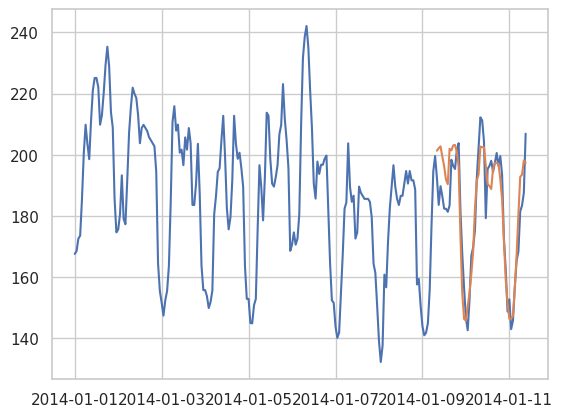

In [22]:


# Forecasting with the final model
forecast = final_model_fit.forecast(steps=len(test))
# 'forecast' contains predictions for the test setrange(0, 3)

# Evaluate the final model
mse = mean_squared_error(test, forecast)
print(f'Final ARIMA{best_order} MSE={mse:.3f}')

plt.plot(ts)
plt.plot(forecast)


**`Effect of different Parameters set on MSE 3D plot`**

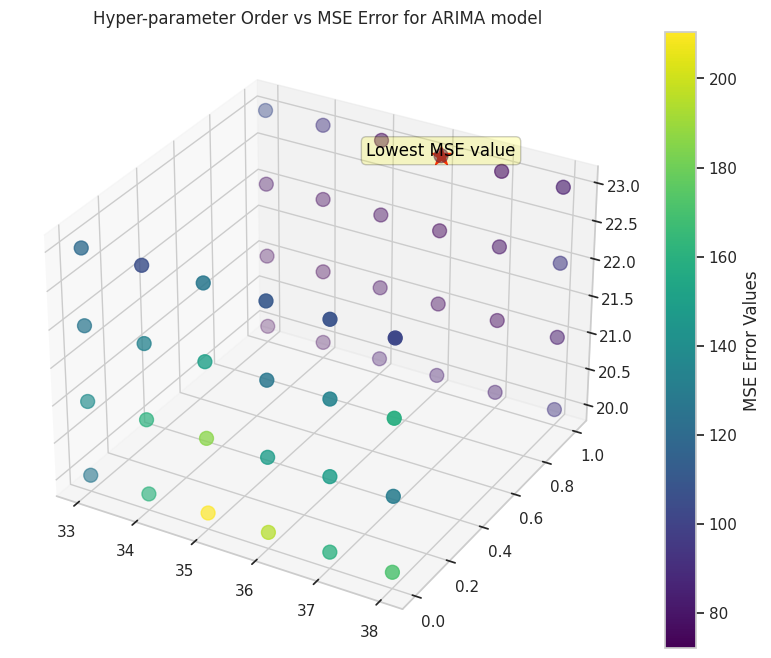

In [23]:
# Unpacking points
x, y, z = zip(*all_orders)

# Find the index of the minimum value
min_value_index = all_order_mse.index(min(all_order_mse))
min_point = all_orders[min_value_index]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plotting
scatter = ax.scatter(x, y, z, c=all_order_mse, cmap='viridis', s=100)
cbar = plt.colorbar(scatter)
cbar.set_label('MSE Error Values')

# Highlighting the lowest point with a star marker
ax.scatter(min_point[0], min_point[1], min_point[2], color='red', marker='*', s=200)
# Adding comment above the lowest point
annotation_text = 'Lowest MSE value'
bbox_props = dict(boxstyle='round,pad=0.3', fc='yellow', 
                  ec='black', lw=1, alpha=0.2)
ax.text(min_point[0], min_point[1], min_point[2], annotation_text, color='black',
        fontsize=12, ha='center', bbox=bbox_props)

ax.set_title('Hyper-parameter Order vs MSE Error for ARIMA model')
plt.show()

**`R-Squared and RMSE errors for ARIMA model`**

R-squared: 0.804462132517455
RMSE: 8.494552603630757


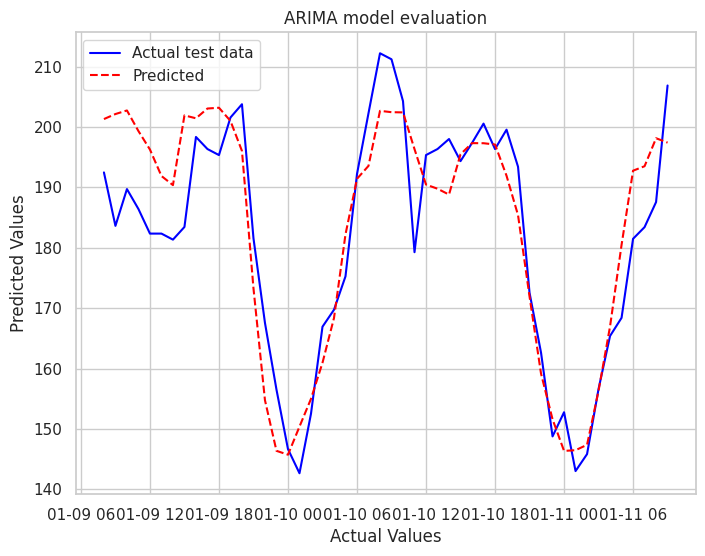

In [24]:
r_squared = r2_score(test, forecast)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f'R-squared: {r_squared}')
print(f'RMSE: {rmse}')

# Plotting the actual vs predicted data
plt.figure(figsize=(8, 6))
plt.plot(test, color='blue', label='Actual test data')
plt.plot(forecast, color='red', linestyle='--', label='Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('ARIMA model evaluation')
plt.legend()
plt.show()

**`Evaluating pre-ETS-ARIMA model on sample`**

In [25]:
# Define the range of p, d, q values for hyperparameter tuning
p_values_trend = range(31, 36)
d_values_trend = range(0, 2)
q_values_trend = range(20, 23)

# Find the best ARIMA hyperparameters
best_order, trnd_orders, trnd_mse = evaluate_models(trend_train, 
                                                    trend_test, 
                                                    p_values_trend, 
                                                    d_values_trend,
                                                    q_values_trend,
                                                    filename='metrics-for-ets-arima-trend.csv')

# Final model training
final_model = ARIMA(trnd, order=best_order)
final_model_trend_fit = final_model.fit()


ARIMA(31, 0, 20) MSE=20.404 RMSE=4.517 R-squared=-0.905
ARIMA(31, 0, 21) MSE=22.366 RMSE=4.729 R-squared=-1.088
ARIMA(31, 0, 22) MSE=14.937 RMSE=3.865 R-squared=-0.395
ARIMA(31, 1, 20) MSE=38.166 RMSE=6.178 R-squared=-2.564
ARIMA(31, 1, 21) MSE=34.181 RMSE=5.846 R-squared=-2.192
ARIMA(31, 1, 22) MSE=38.822 RMSE=6.231 R-squared=-2.625
ARIMA(32, 0, 20) MSE=12.115 RMSE=3.481 R-squared=-0.131
ARIMA(32, 0, 21) MSE=27.056 RMSE=5.201 R-squared=-1.526
ARIMA(32, 0, 22) MSE=16.165 RMSE=4.021 R-squared=-0.509
ARIMA(32, 1, 20) MSE=35.448 RMSE=5.954 R-squared=-2.310
ARIMA(32, 1, 21) MSE=35.155 RMSE=5.929 R-squared=-2.283
ARIMA(32, 1, 22) MSE=36.138 RMSE=6.012 R-squared=-2.374
ARIMA(33, 0, 20) MSE=21.423 RMSE=4.628 R-squared=-1.000
ARIMA(33, 0, 21) MSE=33.171 RMSE=5.759 R-squared=-2.097
ARIMA(33, 0, 22) MSE=48.459 RMSE=6.961 R-squared=-3.525
ARIMA(33, 1, 20) MSE=34.303 RMSE=5.857 R-squared=-2.203
ARIMA(33, 1, 21) MSE=29.108 RMSE=5.395 R-squared=-1.718
ARIMA(33, 1, 22) MSE=52.502 RMSE=7.246 R-squared

In [26]:
# Define the range of p, d, q values for hyperparameter tuning
p_values_season = range(31, 36)
d_values_season = range(0, 1)
q_values_season = range(20, 23)

# Find the best ARIMA hyperparameters
best_order,season_orders,season_mse = evaluate_models(season_train, season_test, p_values_season,
                             d_values_season,
                             q_values_season, 
                             filename='metrics-for-ets-arima-season.csv')

# Final model training
final_model = ARIMA(season, order=best_order)
final_seasonal_model_fit = final_model.fit()


ARIMA(31, 0, 20) MSE=0.505 RMSE=0.711 R-squared=0.999
ARIMA(31, 0, 21) MSE=0.453 RMSE=0.673 R-squared=0.999
ARIMA(31, 0, 22) MSE=0.901 RMSE=0.949 R-squared=0.997
ARIMA(32, 0, 20) MSE=0.717 RMSE=0.847 R-squared=0.998
ARIMA(32, 0, 21) MSE=0.814 RMSE=0.902 R-squared=0.998
ARIMA(32, 0, 22) MSE=0.926 RMSE=0.962 R-squared=0.997
ARIMA(33, 0, 20) MSE=0.697 RMSE=0.835 R-squared=0.998
ARIMA(33, 0, 21) MSE=0.743 RMSE=0.862 R-squared=0.998
ARIMA(33, 0, 22) MSE=1.463 RMSE=1.210 R-squared=0.996
ARIMA(34, 0, 20) MSE=0.737 RMSE=0.859 R-squared=0.998
ARIMA(34, 0, 21) MSE=0.885 RMSE=0.941 R-squared=0.998
ARIMA(34, 0, 22) MSE=0.912 RMSE=0.955 R-squared=0.997
ARIMA(35, 0, 20) MSE=0.687 RMSE=0.829 R-squared=0.998
ARIMA(35, 0, 21) MSE=0.876 RMSE=0.936 R-squared=0.998
ARIMA(35, 0, 22) MSE=1.040 RMSE=1.020 R-squared=0.997
Best ARIMA(31, 0, 21) MSE=0.453


In [27]:
# Define the range of p, d, q values for hyperparameter tuning
p_values_error = range(32, 36)
d_values_error = range(0, 1)
q_values_error = range(20, 23)

# Find the best ARIMA hyperparameters
best_order, error_orders, error_mse = evaluate_models(error_train, error_test,
                             p_values_error,
                             d_values_error,
                             q_values_error,
                             filename='metrics-for-ets-arima-error.csv')

# Final model training
final_model = ARIMA(error, order=best_order)
final_error_model_fit = final_model.fit()


ARIMA(32, 0, 20) MSE=39.240 RMSE=6.264 R-squared=-0.378
ARIMA(32, 0, 21) MSE=40.423 RMSE=6.358 R-squared=-0.419
ARIMA(32, 0, 22) MSE=45.612 RMSE=6.754 R-squared=-0.602
ARIMA(33, 0, 20) MSE=39.052 RMSE=6.249 R-squared=-0.371
ARIMA(33, 0, 21) MSE=46.986 RMSE=6.855 R-squared=-0.650
ARIMA(33, 0, 22) MSE=57.332 RMSE=7.572 R-squared=-1.013
ARIMA(34, 0, 20) MSE=45.445 RMSE=6.741 R-squared=-0.596
ARIMA(34, 0, 21) MSE=48.722 RMSE=6.980 R-squared=-0.711
ARIMA(34, 0, 22) MSE=64.198 RMSE=8.012 R-squared=-1.254
ARIMA(35, 0, 20) MSE=45.165 RMSE=6.720 R-squared=-0.586
ARIMA(35, 0, 21) MSE=48.939 RMSE=6.996 R-squared=-0.718
ARIMA(35, 0, 22) MSE=63.393 RMSE=7.962 R-squared=-1.226
Best ARIMA(33, 0, 20) MSE=39.052


**`Effect of different Parameter set on MSE values for Error, Trend and Season test data`**

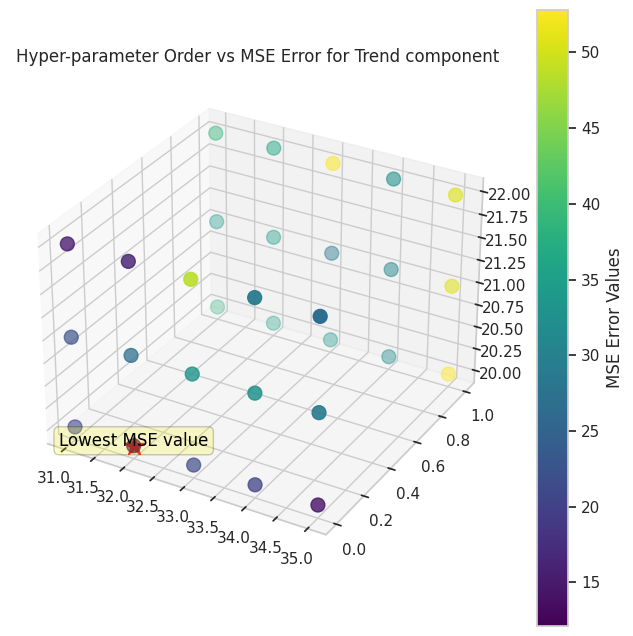

In [88]:
# Unpacking points
x, y, z = zip(*trnd_orders)

# Find the index of the minimum value
min_value_index = trnd_mse.index(min(trnd_mse))
min_point = trnd_orders[min_value_index]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plotting
scatter = ax.scatter(x, y, z, c=trnd_mse, cmap='viridis', s=100)
cbar = plt.colorbar(scatter)
cbar.set_label('MSE Error Values')

# Highlighting the lowest point with a star marker
ax.scatter(min_point[0], min_point[1], min_point[2], color='red', marker='*', s=200)
# Adding comment above the lowest point
annotation_text = 'Lowest MSE value'
bbox_props = dict(boxstyle='round,pad=0.3', fc='yellow', 
                  ec='black', lw=1, alpha=0.2)
ax.text(min_point[0], min_point[1], min_point[2], annotation_text, color='black',
        fontsize=12, ha='center', bbox=bbox_props)

ax.set_title('Hyper-parameter Order vs MSE for Trend component')
plt.show()

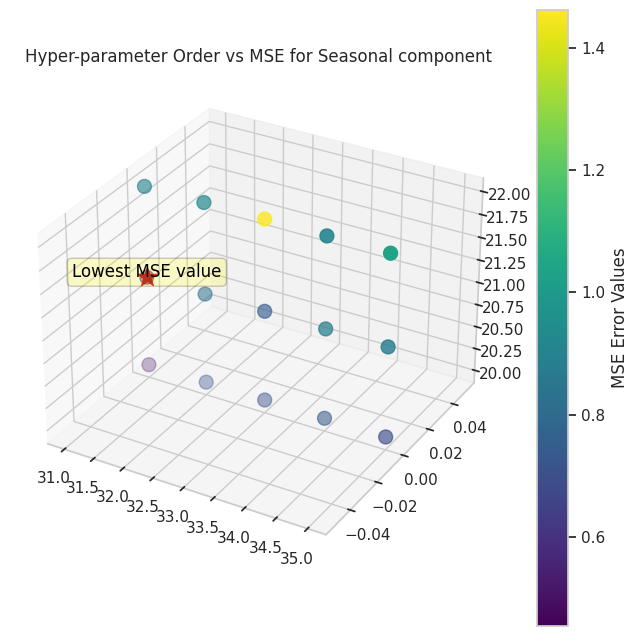

In [102]:
# Unpacking points
x, y, z = zip(*season_orders)

# Find the index of the minimum value
min_value_index = season_mse.index(min(season_mse))
min_point = season_orders[min_value_index]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plotting
scatter = ax.scatter(x, y, z, c=season_mse, cmap='viridis', s=100)
cbar = plt.colorbar(scatter)
cbar.set_label('MSE Error Values')

# Highlighting the lowest point with a star marker
ax.scatter(min_point[0], min_point[1], min_point[2], color='red', marker='*', s=200)
# Adding comment above the lowest point
annotation_text = 'Lowest MSE value'
bbox_props = dict(boxstyle='round,pad=0.3', fc='yellow', 
                  ec='black', lw=1, alpha=0.2)
ax.text(min_point[0], min_point[1], min_point[2], annotation_text, color='black',
        fontsize=12, ha='center', bbox=bbox_props)

ax.set_title('Hyper-parameter Order vs MSE for Seasonal component')
plt.show()

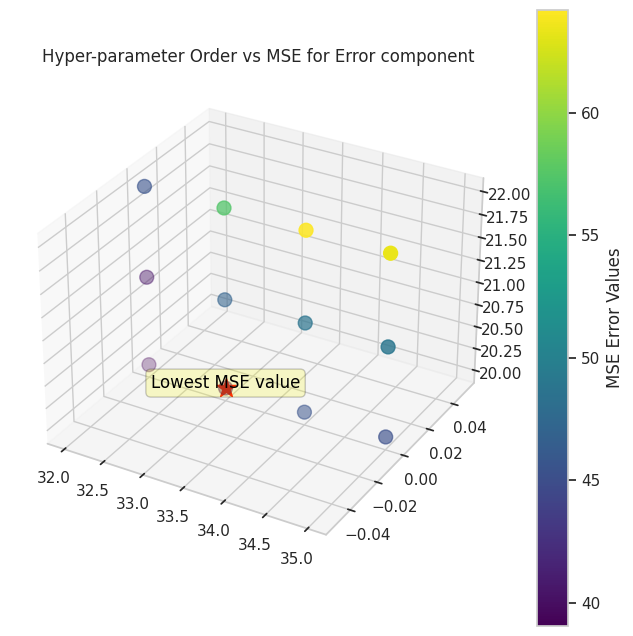

In [101]:
# Unpacking points
x, y, z = zip(*error_orders)

# Find the index of the minimum value
min_value_index = error_mse.index(min(error_mse))
min_point = error_orders[min_value_index]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plotting
scatter = ax.scatter(x, y, z, c=error_mse, cmap='viridis', s=100)
cbar = plt.colorbar(scatter)
cbar.set_label('MSE Error Values')

# Highlighting the lowest point with a star marker
ax.scatter(min_point[0], min_point[1], min_point[2], color='red', marker='*', s=200)
# Adding comment above the lowest point
annotation_text = 'Lowest MSE value'
bbox_props = dict(boxstyle='round,pad=0.3', fc='yellow', 
                  ec='black', lw=1, alpha=0.2)
ax.text(min_point[0], min_point[1], min_point[2], annotation_text, color='black',
        fontsize=12, ha='center', bbox=bbox_props)

ax.set_title('Hyper-parameter Order vs MSE for Error component')
plt.show()

**`Give the Start and End date of future Forecasting`**

**`Choose option 1 or 2 then run the next cells same`**

In [33]:
#OPTION 1: run this line to compare ARIMA only to pre-ETS-ARIMA
last_timestamp = train.index[-1]

In [22]:
#OPTION 2: run this line to forecast the future
last_timestamp = ts.index[-1]

In [42]:
# Calculate the start datetime for prediction
start_prediction= last_timestamp + pd.DateOffset(hours=1)
# Calculate the end datetime for prediction (12 hours after start)
end_prediction= start_prediction + pd.DateOffset(hours=len(test))

**`Do the future forecasting`**

In [43]:
# Forecasting Trend with the final model
trend_forecast = final_model_trend_fit.predict(start=start_prediction, end=end_prediction)

# Forecasting Seasonality with the final model
season_forecast = final_seasonal_model_fit.predict(start=start_prediction, end=end_prediction)

# Forecasting Errors with the final model
error_forecast = final_error_model_fit.predict(start=start_prediction, end=end_prediction)

**`Reconstruct the predicted time series`**

In [70]:
pre_ets_arima_hypertune_tune_RECONSTRUCTED = trend_forecast+season_forecast+error_forecast

**`Comparing ETS of test data vs ETS of predicted data`**

In [65]:
result = seasonal_decompose(test, model='additive')

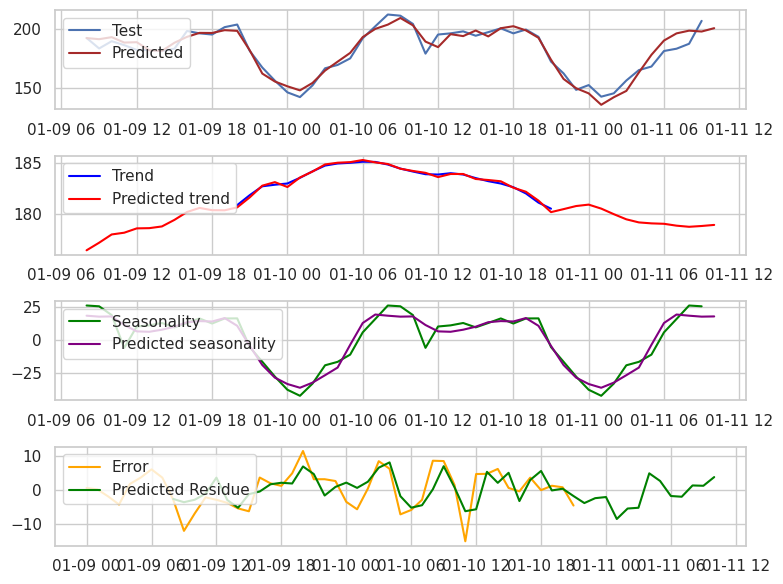

In [69]:
# Plot the decomposition
plt.figure(figsize=(8, 6))

plt.subplot(411)
plt.plot(test, label='Test')
plt.plot(pre_ets_arima_hypertune_tune_RECONSTRUCTED, label='Predicted', color='brown')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='blue')
plt.plot(trend_forecast, label='Predicted trend', color='red')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality', color='green')
plt.plot(season_forecast, label='Predicted seasonality', color='purple')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(error_test, label='Error', color='orange')
plt.plot(error_forecast, label='Predicted Residue', color='green')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

**`R-Squared and RMSE errors for pre-ETS-ARIMA model`**

R-squared: 0.9203529730662968
RMSE: 5.421380101369927


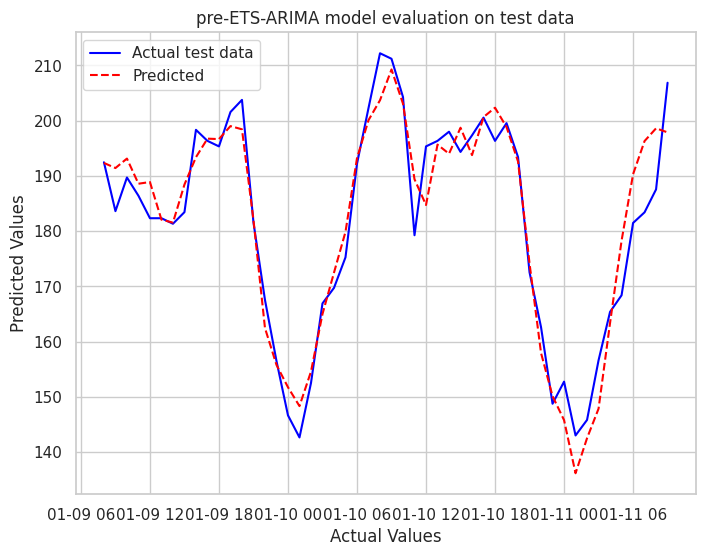

In [80]:
r_squared = r2_score(test, pre_ets_arima_hypertune_tune_RECONSTRUCTED[:-1])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, pre_ets_arima_hypertune_tune_RECONSTRUCTED[:-1]))

print(f'R-squared: {r_squared}')
print(f'RMSE: {rmse}')

# Plotting the actual vs predicted data
plt.figure(figsize=(8, 6))
plt.plot(test, color='blue', label='Actual test data')
plt.plot(pre_ets_arima_hypertune_tune_RECONSTRUCTED[:-1], color='red', linestyle='--', label='Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('pre-ETS-ARIMA model evaluation on test data')
plt.legend()
plt.show()